In [1]:
%load_ext autoreload
%autoreload 2
import tifffile as tif
import matplotlib.pyplot as plt
import numpy as np
import carreno.processing.patches as patches
import tensorflow as tf

# Patchify 2D example
For the sake of my RAM, we divide images in patches

(90, 90, 3) float64


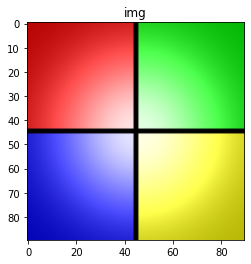

In [2]:
def makeGaussian(size, fwhm = 3, center=None):
    # https://stackoverflow.com/questions/7687679/how-to-generate-2d-gaussian-with-python
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)


def windows_logo(size):
    # was bored sorry
    half = size // 2
    windows_logo = np.zeros((size, size, 3))
    windows_logo[:half, :half,  0] = 0.7
    windows_logo[:half,  half:, 1] = 0.7
    windows_logo[ half:,:half,  2] = 0.7
    windows_logo[ half:, half:,:2] = 0.7
    light = makeGaussian(size, size * 0.6) * 0.9
    windows_logo = np.clip(windows_logo + np.stack([light]*3, axis=2), 0, 1)
    sep = max(1, size * 0.01)
    windows_logo[half-sep:half+sep, :] = 0
    windows_logo[:, half-sep:half+sep] = 0
    # now add distortion lol
    return windows_logo

img = windows_logo(90)
    
print(img.shape, img.dtype)
plt.imshow(img)
plt.title("img")
plt.show()

## Patchify function

patch shape (40, 40, 3)
order : (3, 4, 1)
nb of patches : 12


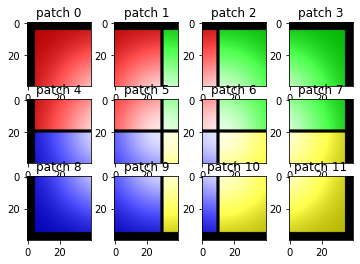

In [3]:
patch_shape = (40, 40, 3)
stride = (30, 20, 3)

patch = patches.patchify(img, patch_shape, stride, 0, 'constant', 0)
patch, order = patches.reshape_patchify(patch, len(patch_shape))
print("patch shape", patch.shape[1:])
print("order :", order)
print("nb of patches :", len(patch))

for i in range(len(patch)):
    plt.subplot(order[0],order[1],i+1)
    plt.imshow(patch[i])
    plt.title("patch " + str(i))
plt.show()

## Unpatchify with nearest
Overlap favor nearest pixel to center of patch

12 (3, 4, 1) (30, 20, 3)
previous shape : (90, 90, 3)
new shape : (100, 100, 3)


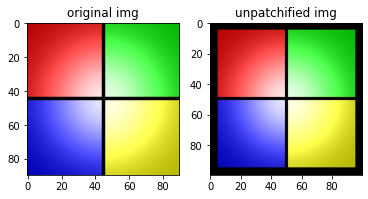

In [4]:
plt.subplot(121)
plt.imshow(img)
plt.title('original img')

def iterator(xs):
    for x in xs:
        yield x

# note that shape might difer from the original because of patch shape
print(len(patch), order, stride)
unpatch = patches.unpatchify_w_nearest(iterator(patch), order, patch_shape, stride)
print("previous shape :", img.shape)
print("new shape :", unpatch.shape)
    
plt.subplot(122)
plt.imshow(unpatch)
plt.title('unpatchified img')  # nice verb
    
plt.show()

## Unpatchify with weights
Overlaps are summed up and normalized between 0 and 1

previous shape : (90, 90, 3)
new shape : (100, 100, 3)


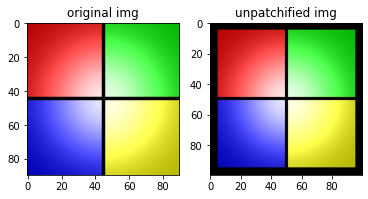

In [5]:
plt.subplot(121)
plt.imshow(img)
plt.title('original img')

def iterator(xs):
    for x in xs:
        yield x

# note that shape might difer from the original because of patch shape
unpatch = patches.unpatchify_w_weight(iterator(patch), order, patch_shape, stride, weight=None)
print("previous shape :", img.shape)
print("new shape :", unpatch.shape)

plt.subplot(122)
plt.imshow(unpatch)
plt.title('unpatchified img')  # nice verb
    
plt.show()

## Unpatchifying with nearest
trying it now on actual data, we see that no weights can really bring out the patch outline when overlap is features 2 opposites classes

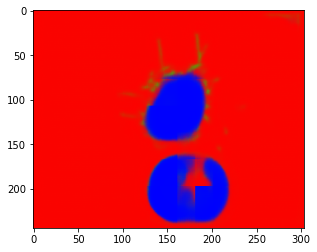

In [6]:
x = tif.imread("../data/dataset/input/slik3.tif")
stride = (1, 30, 20)
model = tf.keras.models.load_model("../data/output/model/unet2D_basic.h5", compile=False)
pred = patches.volume_pred_from_img(model, x, stride, None)
plt.imshow(pred[35])
plt.show()

## Unpatchifying with weights
I hope to prevent this by averaging overlaps together with a weigthed distribution, making the patches outline less visible

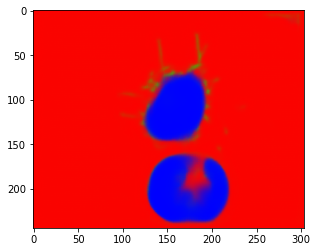

In [7]:
# build the smoothing kernel
input_shape = np.array(model.layers[0].input.shape[1:])
half = input_shape // 2
sigma = 10.0
xax = np.arange(-half[1],half[1],1)
yax = np.arange(-half[0],half[0],1)
xx, yy = np.meshgrid(xax,yax)
kernel = np.exp(-(xx**2 + yy**2)/(2*sigma**2))
kernel = kernel[..., np.newaxis]

pred = patches.volume_pred_from_img(model, x, stride, kernel)
plt.imshow(pred[35])
plt.show()

# Patchify 3D example
Again, we divide volumes in patches for the sake of my RAM. Especially with volumes...

(39, 235, 297) float32
(39, 235, 297, 3) float32


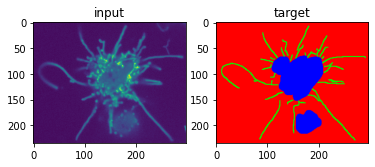

In [8]:
x = tif.imread("../data/dataset/input/slik3.tif")
y = tif.imread("../data/dataset/target/slik3.tif").astype(np.float32)

print(x.shape, x.dtype)
print(y.shape, y.dtype)

slice = 13
plt.subplot(121)
plt.title("input")
plt.imshow(x[slice])
plt.subplot(122)
plt.title("target")
plt.imshow(y[slice])
plt.show()

## Patchify function

patch shape (48, 96, 96)
order : (1, 4, 6)
nb of patches : 24


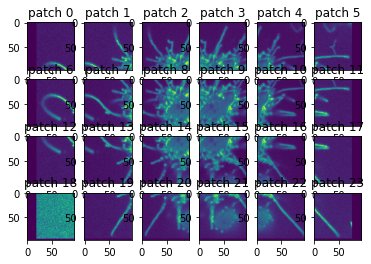

In [9]:
patch_shape = (48, 96, 96)
stride = (48, 48, 48)

patch = patches.patchify(x, patch_shape, stride, 0, 'constant', 0)
patch, order = patches.reshape_patchify(patch, len(patch_shape))
print("patch shape", patch.shape[1:])
print("order :", order)
print("nb of patches :", len(patch))

for i in range(len(patch)):
    plt.subplot(order[1],order[2],i+1)
    plt.imshow(patch[i, slice+4])
    plt.title("patch " + str(i))
plt.show()

# bottom left weirdness is become of plt normalizing intensity range

## Unpatchify with nearest
Overlap favor nearest pixel to center of patch

24 (1, 4, 6) (48, 48, 48)
previous shape : (90, 90, 3)
new shape : (48, 240, 336)


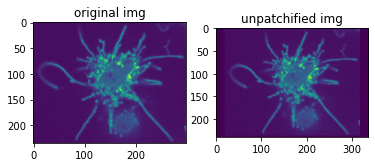

In [10]:
plt.subplot(121)
plt.imshow(x[slice])
plt.title('original img')

def iterator(xs):
    for x in xs:
        yield x

# note that shape might difer from the original because of patch shape
print(len(patch), order, stride)
unpatch = patches.unpatchify_w_nearest(iterator(patch), order, patch_shape, stride)
print("previous shape :", img.shape)
print("new shape :", unpatch.shape)
    
plt.subplot(122)
plt.imshow(unpatch[slice+4])
plt.title('unpatchified img')
    
plt.show()

## Unpatchify with weights
Overlaps are summed up and normalized between 0 and 1

(48, 96, 96)


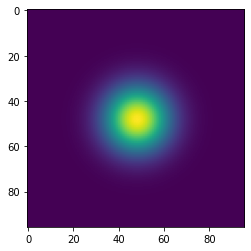

In [11]:
# first build the smoothing kernel
sigma = 10.0     # width of kernel
xax = np.arange(-48,48,1)   # coordinate arrays -- make sure they contain 0!
yax = np.arange(-24,24,1)
zax = np.arange(-48,48,1)
xx, yy, zz = np.meshgrid(xax,yax,zax)
kernel = np.exp(-(xx**2 + yy**2 + zz**2)/(2*sigma**2))

print(kernel.shape)
plt.imshow(kernel[kernel.shape[0] // 2])
plt.show()

previous shape : (90, 90, 3)
new shape : (48, 240, 336) 0.0 1.0


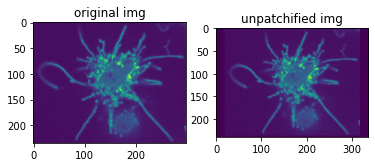

In [12]:
plt.subplot(121)
plt.imshow(x[slice])
plt.title('original img')

def iterator(xs):
    for x in xs:
        yield x

# note that shape might difer from the original because of patch shape
unpatch = patches.unpatchify_w_weight(iterator(patch), order, patch_shape, stride, weight=kernel)
print("previous shape :", img.shape)
print("new shape :", unpatch.shape, unpatch.min(), unpatch.max())

plt.subplot(122)
plt.imshow(unpatch[slice+4])
plt.title('unpatchified img')
    
plt.show()

Again now, trying unpatchifying with volume predictions. One with nearest, and two with weights

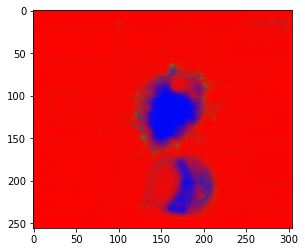

In [13]:
model = tf.keras.models.load_model("../data/output/model/unet3D_basic.h5", compile=False)
pred = patches.volume_pred_from_vol(model, x, stride, None)
plt.imshow(pred[35])
plt.show()

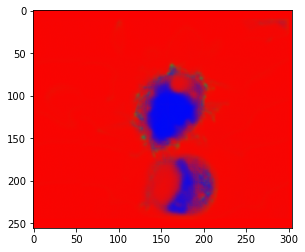

In [14]:
# build the smoothing kernel
input_shape = np.array(model.layers[0].input.shape[1:])
half = input_shape // 2
sigma = 10.0
xax = np.arange(-half[1],half[1],1)
yax = np.arange(-half[0],half[0],1)
zax = np.arange(-half[2],half[2],1)
xx, yy, zz = np.meshgrid(xax,yax,zax)
kernel = np.exp(-(xx**2 + yy**2 + zz**2)/(2*sigma**2))
kernel = kernel[..., np.newaxis]

pred = patches.volume_pred_from_vol(model, x, stride, kernel)
plt.imshow(pred[35])
plt.show()

I divide by the weight at the end and I fear that my distribution is cancelled because of it.  

To make sure our smoothing isn't just a normal average, let's try weights which should wield weird results.

c:\users\user\desktop\etude\linum\carreno-cytonemes\carreno\processing\patches.py:235: RuntimeWarning: invalid value encountered in divide
  return nd / nd_weight


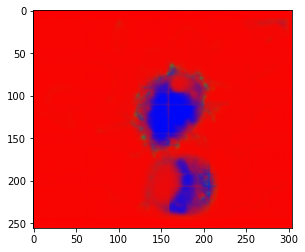

In [15]:
# build meshgrid kernel
input_shape = np.array(model.layers[0].input.shape[1:])
yy, zz, xx = np.meshgrid(np.linspace(0,1,input_shape[0]),np.linspace(0,1,input_shape[1]),np.linspace(0,1,input_shape[2]))
plt.imshow(xx); plt.show()
kernel = xx[..., np.newaxis]

pred = patches.volume_pred_from_vol(model, x, stride, kernel)
plt.imshow(pred[35])
plt.show()